# Part 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cp "drive/MyDrive/Question Generation/vae/models.py" .
%cd '/content/drive/MyDrive/Question Generation/vae/'
!pwd

/content/drive/MyDrive/Question Generation/vae
/content/drive/MyDrive/Question Generation/vae


In [ ]:
!nvcc --version

import torch
print("\nPytorch version: ", torch.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0

Pytorch version:  2.0.0+cu118


In [ ]:
!pip install -q transformers
!pip install -q -U sentence-transformers
## scatter 1.12+cu113
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
# scatter 1.13+cu116
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q json-lines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 93.8 MB/s eta 0:00:00


In [ ]:
import argparse
import json
import os

from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm
from transformers import BertTokenizer
import numpy as np
from models2 import DiscreteVAE
from squad_utils import (InputFeatures,
                         read_examples,SquadExample,read_squad_examples,_improve_answer_span,_check_is_max_context)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
filename = 'sciq_test'
file_ext = '.json'
filedir = '../data/squad/'

In [ ]:
def loadData(filedir,filename,file_ext):
  with open(filedir + filename + file_ext) as f:
    data = json.load(f)
  return data

In [ ]:
def re_id(data,filedir,filename,file_ext):
  contextIndex = 200000
  added = 0
  data2 = dict()
  data2['data'] = list()
  for topic in data['data']:
    data2['data'].append(dict())
    data2['data'][-1]['title'] = topic['title']
    data2['data'][-1]['paragraphs']=list()
    for paragraph in topic['paragraphs']:
      if len(paragraph['qas']) == 0:
        continue
      # elif added % 4 != 0:
      #   added += 1
      #   continue
      data2['data'][-1]['paragraphs'].append(dict())
      data2['data'][-1]['paragraphs'][-1]['context'] = paragraph['context']
      data2['data'][-1]['paragraphs'][-1]['qas'] = [paragraph['qas'][0]]
      data2['data'][-1]['paragraphs'][-1]['qas'][0]['id']=contextIndex
      contextIndex += 1
      added += 1
  with open(filedir + 'latent/' + filename + '_withCID'+file_ext,'w') as f:
    json.dump(data2, f, ensure_ascii=False)
  return data2

In [ ]:
data = re_id(loadData(filedir,filename,file_ext), filedir,filename,file_ext)
# data = loadData(filedir+'latent/',filename+ '_withCID',file_ext)

In [ ]:
from copy import deepcopy
import collections
def convert_examples_to_harv_features(examples, tokenizer, max_seq_length,
                                      doc_stride, max_query_length, is_training):
    """Loads a data file into a list of `InputBatch`s.
       each example only contains a sequence of ids for context(paragraph)
    """


    features = []
    for example in tqdm(examples, total=len(examples)):
        unique_id = example.qas_id
        query_tokens = tokenizer.tokenize(example.question_text)

        if len(query_tokens) > max_query_length:
            query_tokens = query_tokens[0:max_query_length]

        tok_to_orig_index = []
        orig_to_tok_index = []
        all_doc_tokens = []
        for (i, token) in enumerate(example.doc_tokens):
            orig_to_tok_index.append(len(all_doc_tokens))
            sub_tokens = tokenizer.tokenize(token)
            for sub_token in sub_tokens:
                tok_to_orig_index.append(i)
                all_doc_tokens.append(sub_token)

        tok_start_position = None
        tok_end_position = None
        if is_training and example.is_impossible:
            tok_start_position = -1
            tok_end_position = -1
        if is_training and not example.is_impossible:
            tok_start_position = orig_to_tok_index[example.start_position]
            if example.end_position < len(example.doc_tokens) - 1:
                tok_end_position = orig_to_tok_index[example.end_position + 1] - 1
            else:
                tok_end_position = len(all_doc_tokens) - 1
            (tok_start_position, tok_end_position) = _improve_answer_span(
                all_doc_tokens, tok_start_position, tok_end_position, tokenizer,
                example.orig_answer_text)

        # The -3 accounts for [CLS], [SEP] and [SEP]
        max_tokens_for_doc = max_seq_length - len(query_tokens) - 3

        # We can have documents that are longer than the maximum sequence length.
        # To deal with this we do a sliding window approach, where we take chunks
        # of the up to our max length with a stride of `doc_stride`.
        _DocSpan = collections.namedtuple(  # pylint: disable=invalid-name
            "DocSpan", ["start", "length"])
        doc_spans = []
        start_offset = 0
        while start_offset < len(all_doc_tokens):
            length = len(all_doc_tokens) - start_offset
            if length > max_tokens_for_doc:
                length = max_tokens_for_doc
            doc_spans.append(_DocSpan(start=start_offset, length=length))
            if start_offset + length == len(all_doc_tokens):
                break
            start_offset += min(length, doc_stride)

        for (doc_span_index, doc_span) in enumerate(doc_spans):
            tokens = []
            token_to_orig_map = {}
            token_is_max_context = {}
            segment_ids = []
            tokens.append("[CLS]")
            segment_ids.append(0)
            for token in query_tokens:
                tokens.append(token)
                segment_ids.append(0)
            tokens.append("[SEP]")

            context_tokens = list()
            context_tokens.append("[CLS]")
            for i in range(doc_span.length):
                split_token_index = doc_span.start + i
                token_to_orig_map[len(
                    tokens)] = tok_to_orig_index[split_token_index]

                is_max_context = _check_is_max_context(doc_spans, doc_span_index,
                                                       split_token_index)
                token_is_max_context[len(tokens)] = is_max_context
                tokens.append(all_doc_tokens[split_token_index])
                context_tokens.append(all_doc_tokens[split_token_index])

            tokens.append("[SEP]")
            context_tokens.append("[SEP]")

            if is_training and not example.is_impossible:
                # For training, if our document chunk does not contain an annotation
                # we throw it out, since there is nothing to predict.
                doc_start = doc_span.start
                doc_end = doc_span.start + doc_span.length - 1
                out_of_span = False
                if not (tok_start_position >= doc_start and
                        tok_end_position <= doc_end):
                    out_of_span = True
                if out_of_span:
                    continue

            c_ids = tokenizer.convert_tokens_to_ids(context_tokens)

            while len(c_ids) < max_seq_length:
                c_ids.append(0)

            features.append(
                InputFeatures(
                    unique_id=unique_id,
                    example_index=None,
                    doc_span_index=None,
                    tokens=None,
                    token_to_orig_map=None,
                    token_is_max_context=None,
                    input_ids=None,
                    input_mask=None,
                    c_ids=c_ids,
                    context_tokens=None,
                    q_ids=None,
                    q_tokens=None,
                    answer_text=None,
                    tag_ids=None,
                    segment_ids=None,
                    noq_start_position=None,
                    noq_end_position=None,
                    start_position=None,
                    end_position=None,
                    is_impossible=None))
            unique_id += 1

    return features

In [ ]:
def loadDataset(args):  
    tokenizer = BertTokenizer.from_pretrained(args.bert_model)
    args.tokenizer = tokenizer

    device = torch.cuda.current_device()
    checkpoint = torch.load(args.checkpoint, map_location="cpu")
    vae = DiscreteVAE(checkpoint["args"])
    vae.load_state_dict(checkpoint["state_dict"])
    vae.eval()
    vae = vae.to(device)
    
    examples = read_squad_examples(args.data_file, is_training=True, debug=False)
    features = convert_examples_to_harv_features(examples,
                                                     tokenizer=tokenizer,
                                                     max_seq_length=args.max_c_len,
                                                     max_query_length=args.max_q_len,
                                                     doc_stride=128,
                                                     is_training=True)
    all_index_ids = torch.tensor([f.unique_id for f in features], dtype=torch.long)
    all_c_ids = torch.tensor([f.c_ids for f in features], dtype=torch.long)
    
    data = TensorDataset(all_index_ids,all_c_ids)
    data_loader = DataLoader(data, shuffle=False, batch_size=args.batch_size)

    return data_loader, tokenizer, vae

In [ ]:

def main(args,data_loader, tokenizer, vae):

    genPairs = dict()
    
    for batch in tqdm(data_loader, total=len(data_loader)):        
        contextIndex = batch[0]
        c_ids = batch[1].to(device)
        with torch.no_grad():
            zq_mu, zq_logvar, zq,c_hs,c_h = vae.prior_encoder.forwardQ(c_ids)
            for i in range(4):
                za_prob, za = vae.prior_encoder.forwardA(c_ids, zq,c_hs,c_h)
                batch_q_ids, batch_start, batch_end = vae.generate(zq, za, c_ids)
                for i in range(c_ids.size(0)):
                    _c_ids = c_ids[i].cpu().tolist()
                    q_ids = batch_q_ids[i].cpu().tolist()
                    start_pos = batch_start[i].item()
                    end_pos = batch_end[i].item()                
                    a_ids = _c_ids[start_pos: end_pos+1]
                    c_text = tokenizer.decode(_c_ids, skip_special_tokens=True)
                    q_text = tokenizer.decode(q_ids, skip_special_tokens=True)
                    a_text = tokenizer.decode(a_ids, skip_special_tokens=True)

                    if contextIndex[i].item() in genPairs:
                      if 'method1_question' not in genPairs[contextIndex[i].item()]:
                          genPairs[contextIndex[i].item()]['method1_question'] = q_text
                          genPairs[contextIndex[i].item()]['method1_answer'] = [a_text]
                      else:
                          genPairs[contextIndex[i].item()]['method1_answer'].append(a_text)
                    else:                      
                          genPairs[contextIndex[i].item()]=dict()
                          genPairs[contextIndex[i].item()]['method1_question'] = q_text
                          genPairs[contextIndex[i].item()]['method1_answer'] = [a_text]

        # sample latent variable K times
        for kIndex in range(args.k):
            # testQ = []
            with torch.no_grad():
                ## prior takes context, and returns latent for q and a
                zq_mu, zq_logvar, zq, za_prob, za = vae.prior_encoder(c_ids)
                batch_q_ids, batch_start, batch_end = vae.generate(zq, za, c_ids)
            for i in range(c_ids.size(0)):
                _c_ids = c_ids[i].cpu().tolist()
                q_ids = batch_q_ids[i].cpu().tolist()
                start_pos = batch_start[i].item()
                end_pos = batch_end[i].item()                
                a_ids = _c_ids[start_pos: end_pos+1]
                c_text = tokenizer.decode(_c_ids, skip_special_tokens=True)
                q_text = tokenizer.decode(q_ids, skip_special_tokens=True)
                a_text = tokenizer.decode(a_ids, skip_special_tokens=True)

                if not contextIndex[i].item() in genPairs:
                  genPairs[contextIndex[i].item()] = dict()
                elif 'generated_answers' in genPairs[contextIndex[i].item()]:
                  genPairs[contextIndex[i].item()]['generated_answers'].append(a_text)
                  genPairs[contextIndex[i].item()]['generated_questions'].append(q_text)   
                else:
                  genPairs[contextIndex[i].item()]['generated_answers']=[a_text]
                  genPairs[contextIndex[i].item()]['generated_questions']=[q_text]

    return genPairs

In [ ]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def setArguments(dataFile,myData=[], maxParaCount=float("inf"), seed=1004, bert_model="bert-base-uncased", max_length=384, batch_size=64, ratio=1, k = 1):
    args = dict()
    args['maxParaCount'] = maxParaCount
    args['seed'] = seed
    args['bert_model'] = bert_model
    args['max_length'] = max_length
    args['batch_size'] = batch_size
    args['data_file'] = dataFile
    args['checkpoint'] = "../save/vae-checkpoint/best_f1_model.pt"
    args['output_dir'] = "../data/synthetic_data/"
    args['ratio'] = ratio
    args['k'] = k
    args['max_c_len']=384
    args['max_q_len']=64
    args['squad'] = True
    
    return dotdict(args)    

In [ ]:
k = 40
datafile = filedir + 'latent/' + filename + '_withCID' + file_ext
args = setArguments(dataFile=datafile, k=k)
data_loader, tokenizer, vae = loadDataset(args)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.se

In [ ]:
genPairs = main(args, data_loader, tokenizer, vae)

100%|██████████| 13/13 [37:36<00:00, 173.60s/it]


In [ ]:
data = loadData(filedir + 'latent/', filename+ '_withCID', file_ext)

for topic in data['data']:
  for paragraph in topic['paragraphs']:
    if len(paragraph['qas']) == 0:
      continue
    context_index = paragraph['qas'][0]['id']
    paragraph['generated_questions'] = genPairs[context_index]['generated_questions']
    paragraph['generated_answers'] = genPairs[context_index]['generated_answers']
    paragraph['method1'] = dict()
    paragraph['method1']['generated_question'] = genPairs[context_index]['method1_question'] 
    paragraph['method1']['generated_choices'] = genPairs[context_index]['method1_answer'] 
    
  
with open(filedir + 'objective_output/' + filename + '_latent_output' + file_ext,'w') as f:
  json.dump(data, f, ensure_ascii=False)

In [ ]:
# from google.colab import runtime
# runtime.unassign()

In [ ]:
# index = 18

# dictIndex = list(genPairs.keys())[index]
# # the below line, we can alter with the middle index and the output should stay the same
# genPairs[dictIndex][1]['context']

# Part 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Question Generation/vae/'
!pwd
import torch

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Question Generation/vae
/content/drive/MyDrive/Question Generation/vae


In [ ]:
!pip install -q -U sentence-transformers

In [ ]:
!pip install -q rake-nltk

In [ ]:

import json
import numpy as np
from tqdm import tqdm

In [ ]:
filename = 'sciq_test'
file_ext = '.json'
filedir = '../data/squad/'

In [ ]:
def loadData(filedir,filename,file_ext):
  with open(filedir + filename + file_ext) as f:
    data = json.load(f)
  return data

In [ ]:
from sentence_transformers import SentenceTransformer,util
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
def jaccard_similarity(s1, s2):
    if len(s1) == 0 and len(s2) == 0:
      return 1
    return float(len(s1.intersection(s2)) / len(s1.union(s2)))

In [ ]:
## Method 2: question similarity
def method2(questions, answers, model):
  question_embeddings = model.encode(questions)
  #answer_embeddings = model.encode(answers)

  pairs = []
  ques_ques_similarity = util.cos_sim(question_embeddings, question_embeddings)
  # ans_ans_similarity = np.zeros((len(answers), len(answers))) #util.cos_sim(answer_embeddings, answer_embeddings)

  for i in range(len(answers)):
    ans1_set = set(answers[i].lower().split())
    for j in range(i+1, len(answers)):
      ans2_set = set(answers[j].lower().split())
      jac_loss = 1 - jaccard_similarity(ans1_set, ans2_set)
      ques_ques_similarity[i,j] *= jac_loss
      ques_ques_similarity[j,i] *= jac_loss


  ques_ques_similarity = ques_ques_similarity.fill_diagonal_(0)
  chosenQuestionIndex = torch.argmax(ques_ques_similarity.sum(0))  # finds most similar question to other questions

  ques_ques_similarity[chosenQuestionIndex,chosenQuestionIndex] = 1
  ques_ques_similarity = torch.triu(ques_ques_similarity)
  best_scores = np.argsort(-ques_ques_similarity[chosenQuestionIndex, :])
  altAnswers = []
  for i in best_scores:
    neww = True
    # for old in altAnswers:
    #   if np.round(ans_ans_similarity[old,i], decimals=2) >= 1:
    #     neww = False
    #     break
    if neww:
      altAnswers.append(i)
      if len(altAnswers) >= 4:
        break
        
  question = questions[chosenQuestionIndex]
  choices = [answers[ansIndex] for ansIndex in altAnswers]
  return question, choices

In [ ]:
## Method 3: answer similarity
def method3(questions, answers, model):
  answer_embeddings = model.encode(answers)
  answer_similarity_scores = util.cos_sim(answer_embeddings, answer_embeddings)
  # answer_similarity_scores = np.round(answer_similarity_scores, decimals=3)
  # answer_similarity_scores[answer_similarity_scores>=1] = 0
  answer_similarity_scores = answer_similarity_scores.fill_diagonal_(0)
  chosenAnswerIndex = torch.argmax(answer_similarity_scores.sum(0))
  
  for i in range(len(answers)):
    ans1_set = set(answers[i].lower().split())
    for j in range(i+1, len(answers)):
      ans2_set = set(answers[j].lower().split())
      jac_loss = 1 - jaccard_similarity(ans1_set, ans2_set)
      answer_similarity_scores[i,j] *= jac_loss
      answer_similarity_scores[j,i] *= jac_loss
  
  answer_similarity_scores = torch.triu(answer_similarity_scores)

  altAnswerIndices = [chosenAnswerIndex]
  best_matching = np.argsort(-answer_similarity_scores[chosenAnswerIndex,:])
  for i in best_matching:
    neww = True
    # for oldIndex in altAnswerIndices:
      # if np.round(cosine_scores[oldIndex,i],decimals=2)>=1:
        # neww= False
    if neww:
      altAnswerIndices.append(i)
      if len(altAnswerIndices) >= 4:
        break
        
  # print(f"Question {chosenAnswerIndex}: {myQuestions[chosenAnswerIndex]}")
  # for loopIndex, ansIndex in enumerate(altAnswerIndices):
  #   print(f"A{loopIndex}: {myAnswers[ansIndex]}")
  # print("correct: ", myAnswers[chosenAnswerIndex])
  question = questions[chosenAnswerIndex]
  choices = [answers[ansIndex] for ansIndex in altAnswerIndices]
  correct_answer = answers[chosenAnswerIndex]
  assert correct_answer == choices[0]
  return question, choices

In [ ]:
def genOutput(data,model,filedir,filename,file_ext):
  data2 = dict()
  data2['data'] = list()
  for topic in tqdm(data['data'], total=len(data['data'])):
    data2['data'].append(dict())
    data2['data'][-1]['title'] = topic['title']
    data2['data'][-1]['paragraphs'] = list()
    for paragraph in topic['paragraphs']:
      if len(paragraph['qas']) == 0:
        continue
      data2['data'][-1]['paragraphs'].append(dict())
      data2['data'][-1]['paragraphs'][-1]['context'] = paragraph['context']
      data2['data'][-1]['paragraphs'][-1]['qas'] = paragraph['qas']
      questionList = paragraph['generated_questions']
      answerList = paragraph['generated_answers']

      question1, choices1 = method2(questionList, answerList, model)
      question2, choices2 = method3(questionList, answerList, model)
      data2['data'][-1]['paragraphs'][-1]['method1'] = paragraph['method1']
      data2['data'][-1]['paragraphs'][-1]['method2'] = dict()
      data2['data'][-1]['paragraphs'][-1]['method3'] = dict()
      data2['data'][-1]['paragraphs'][-1]['method2']['generated_question'] = question1
      data2['data'][-1]['paragraphs'][-1]['method3']['generated_question'] = question2
      data2['data'][-1]['paragraphs'][-1]['method2']['generated_choices'] = choices1
      data2['data'][-1]['paragraphs'][-1]['method3']['generated_choices'] = choices2
      
  with open(filedir + 'objective_output/' + filename + 'latentMCQ' + file_ext,'w') as f:
    json.dump(data2, f, ensure_ascii=False)
  return data2

In [ ]:
data = loadData(filedir + 'objective_output/', filename + '_latent_output', file_ext)
genOutput(data,model,filedir,filename,file_ext)

100%|██████████| 1/1 [01:25<00:00, 85.74s/it]


{'data': [{'title': 'All',
   'paragraphs': [{'context': 'oxidants and reductants compounds that are capable of accepting electrons, such as o 2 or f2, are calledoxidants (or oxidizing agents) because they can oxidize other compounds. in the process of accepting electrons, an oxidant is reduced. compounds that are capable of donating electrons, such as sodium metal or cyclohexane (c6h12), are calledreductants (or reducing agents) because they can cause the reduction of another compound. in the process of donating electrons, a reductant is oxidized. these relationships are summarized in equation 3.30: equation 3.30 saylor url: http://www. saylor. org/books.',
     'qas': [{'question': 'Compounds that are capable of accepting electrons, such as o 2 or f2, are called what?',
       'id': 200000,
       'answers': [{'answer_start': 0, 'text': 'oxidants'}],
       'distractors': ['antioxidants', 'oxygen', 'residues']}],
     'method1': {'generated_question': 'what is a reductant process?',


In [ ]:
## Baseline: Getting similar kind of answers from paragraph
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from sentence_transformers import SentenceTransformer,util
# print(-1)
from rake_nltk import Rake
# print(0)
# print(1)
model = SentenceTransformer('all-MiniLM-L6-v2')

def getCloseKeywords(context, answerList):
    rake_nltk_var = Rake()
    rake_nltk_var.extract_keywords_from_text(context)
    
    keywords = rake_nltk_var.get_ranked_phrases()
    answerNestedList = []
    for answer in answerList:
      # answerNoPunc = re.sub(r'[^\w\s]','',answer)
      # numWordsInAns = len(answerNoPunc.split())
      keywords = [key for key in keywords if key != answer]
      answer_embedding = model.encode([answer])
      keywords_embedding = model.encode(keywords)
      answer_keyword_similarity = util.cos_sim(answer_embedding,keywords_embedding)[0,:]
      for i in range(len(keywords)):
        s1 = set(answer.lower().split())
        s2 = set(keywords[i].lower().split())
        jaccard_loss = 1-jaccard_similarity(s1,s2)
        answer_keyword_similarity[i] *= jaccard_loss
      keyword_keyword_similarity = util.cos_sim(keywords_embedding,keywords_embedding)
      best_scores = np.argsort(-answer_keyword_similarity)
      altAnswers = []
      for i in best_scores:
        neww = True
        for old in altAnswers:
          if np.round(keyword_keyword_similarity[old,i], decimals=2) >= 1:
            neww = False
            break
        if neww:
          altAnswers.append(i)
          if len(altAnswers) >= 3:
            break
      answers = [keywords[ansIndex] for ansIndex in altAnswers]
      answerNestedList.append(answers)
    return answerNestedList
    # print(f"Question: {myQuestions[chosenQApair]}")
    # for loopIndex, ansIndex in enumerate(altAnswers):
    #   print(f"A{loopIndex}: {potential_answers[ansIndex]}")
    # print("correct: ", myAnswers[chosenQApair])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
with open(filedir + 'objective_output/' + filename + 'latentMCQ' + file_ext) as f:
  data = json.load(f)
for topic in data['data']:
  for paragraph in topic['paragraphs']:
    answers = []
    answers.append(paragraph['method1']['generated_choices'][0])
    answers.append(paragraph['method2']['generated_choices'][0])
    answers.append(paragraph['method3']['generated_choices'][0])
    answerNestedList = getCloseKeywords(paragraph['context'], answers)
    paragraph['baseline_method1'] = dict()
    paragraph['baseline_method1']['generated_choices']=answerNestedList[0]
    paragraph['baseline_method2'] = dict()
    paragraph['baseline_method2']['generated_choices']=answerNestedList[1]
    paragraph['baseline_method3'] = dict()
    paragraph['baseline_method3']['generated_choices']=answerNestedList[2]
with open(filedir + 'objective_output/' + filename + '_latent_MCQ_baseline' + file_ext,'w') as f:
  json.dump(data, f)

# Evaluation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Question Generation/vae/'
!pwd
import torch

Mounted at /content/drive
/content/drive/MyDrive/Question Generation/vae
/content/drive/MyDrive/Question Generation/vae


In [ ]:
filename = 'sciq_test'
file_ext = '.json'
filedir = '../data/squad/'

In [ ]:
import matplotlib.pyplot as plt

import json
import numpy as np
from tqdm import tqdm

In [ ]:
!pip install -q -U sentence-transformers
from sentence_transformers import SentenceTransformer,util
model = SentenceTransformer('all-MiniLM-L6-v2')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.6 MB/s eta 0:00:00


In [ ]:
def getMCQ_to_grround_truth(mcq_choices):
    context_embeddings = model.encode(mcq_choices)
    # print("ce.shape", context_embeddings.shape)
    if len(context_embeddings) == 1:
      return 2 # no keywords were generated so we return a high error
    return np.mean(context_embeddings[1:,:]  - context_embeddings[0,:], axis=0)

def squared_loss(vec1, vec2):
  return np.sqrt(np.sum((vec1-vec2)**2))

def getScores(data):
  method1_scores= []
  method2_scores= []
  method3_scores= []
  baseline_method1_scores = []
  baseline_method2_scores = []
  baseline_method3_scores = []
  count = 0
  for topic in data['data']:
    for paragraph in topic['paragraphs']:
      qa = paragraph['qas'][0] # there is only 1 qa per paragraph
      average_gt_answer_to_distractor_vector = getMCQ_to_grround_truth([qa['answers'][0]['text']] + [distractor for distractor in qa['distractors']])

      # print([paragraph['method1']['generated_choices']])
      average_gen_method1_to_distractor_vector = getMCQ_to_grround_truth(paragraph['method1']['generated_choices'])
      average_gen_method2_to_distractor_vector = getMCQ_to_grround_truth(paragraph['method2']['generated_choices'])
      average_gen_method3_to_distractor_vector = getMCQ_to_grround_truth(paragraph['method3']['generated_choices'])

      average_gen_baseline_method1_to_distractor_vector = getMCQ_to_grround_truth([paragraph['method1']['generated_choices'][0]] + paragraph['baseline_method1']['generated_choices'])
      average_gen_baseline_method2_to_distractor_vector = getMCQ_to_grround_truth([paragraph['method2']['generated_choices'][0]] + paragraph['baseline_method2']['generated_choices'])
      average_gen_baseline_method3_to_distractor_vector = getMCQ_to_grround_truth([paragraph['method3']['generated_choices'][0]] + paragraph['baseline_method3']['generated_choices'])
      
      
      method1_scores.append(squared_loss(average_gen_method1_to_distractor_vector,average_gt_answer_to_distractor_vector))
      method2_scores.append(squared_loss(average_gen_method2_to_distractor_vector,average_gt_answer_to_distractor_vector))
      method3_scores.append(squared_loss(average_gen_method3_to_distractor_vector,average_gt_answer_to_distractor_vector))
      baseline_method1_scores.append(squared_loss(average_gen_baseline_method1_to_distractor_vector,average_gt_answer_to_distractor_vector))
      baseline_method2_scores.append(squared_loss(average_gen_baseline_method2_to_distractor_vector,average_gt_answer_to_distractor_vector))
      baseline_method3_scores.append(squared_loss(average_gen_baseline_method3_to_distractor_vector,average_gt_answer_to_distractor_vector))
  return method1_scores, method2_scores, method3_scores, baseline_method1_scores, baseline_method2_scores, baseline_method3_scores


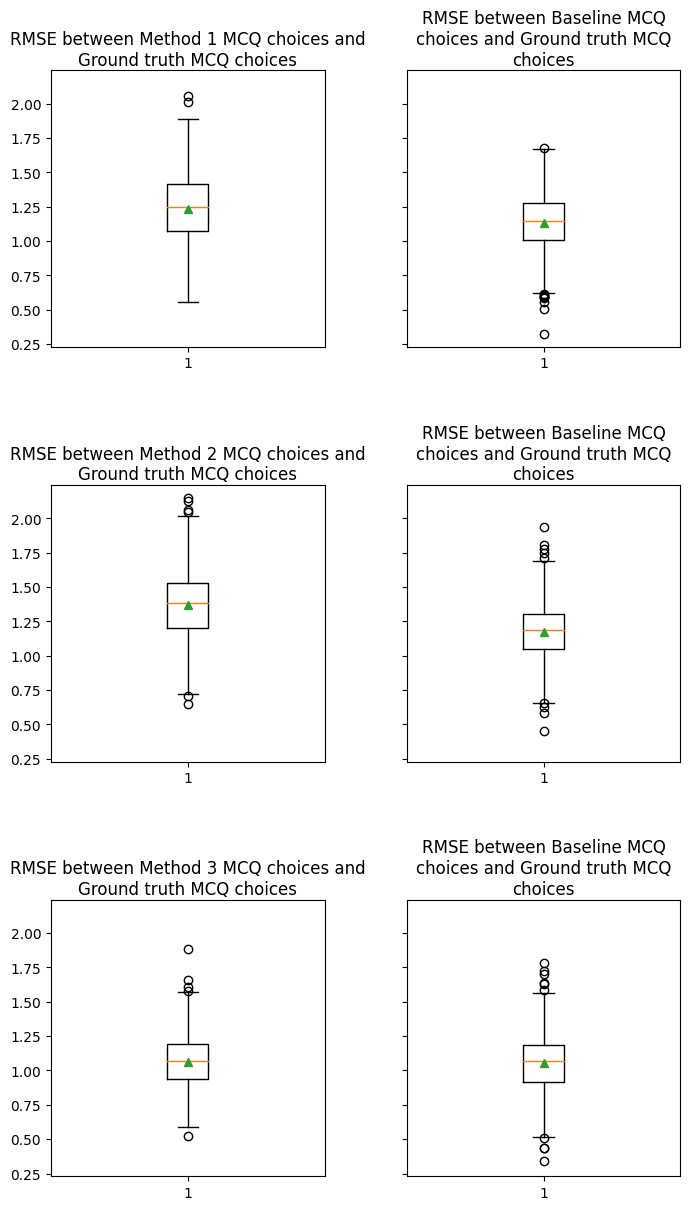

In [ ]:
with open(filedir + 'objective_output/MCQ Gen/' + filename + '_latent_MCQ_baseline' + file_ext) as f:
  data = json.load(f)

method1_scores, method2_scores, method3_scores, baseline_method1_scores, baseline_method2_scores, baseline_method3_scores = getScores(data)
print("Average RMSE")
fig, ax = plt.subplots(nrows=3, ncols=2, sharey=True, figsize=(7,12))
ax[0,0].boxplot(method1_scores, showmeans=True)
ax[0,1].boxplot(baseline_method1_scores, showmeans=True)

ax[1,0].boxplot(method2_scores, showmeans=True)
ax[1,1].boxplot(baseline_method2_scores, showmeans=True)

ax[2,0].boxplot(method3_scores, showmeans=True)
ax[2,1].boxplot(baseline_method3_scores, showmeans=True)

ax[0,0].set_title('RMSE between Method 1 MCQ choices and Ground truth MCQ choices', wrap=True)
ax[0,1].set_title('RMSE between Baseline MCQ choices and Ground truth MCQ choices', wrap=True)
ax[1,0].set_title('RMSE between Method 2 MCQ choices and Ground truth MCQ choices', wrap=True)
ax[1,1].set_title('RMSE between Baseline MCQ choices and Ground truth MCQ choices', wrap=True)
ax[2,0].set_title('RMSE between Method 3 MCQ choices and Ground truth MCQ choices', wrap=True)
ax[2,1].set_title('RMSE between Baseline MCQ choices and Ground truth MCQ choices', wrap=True)
fig.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

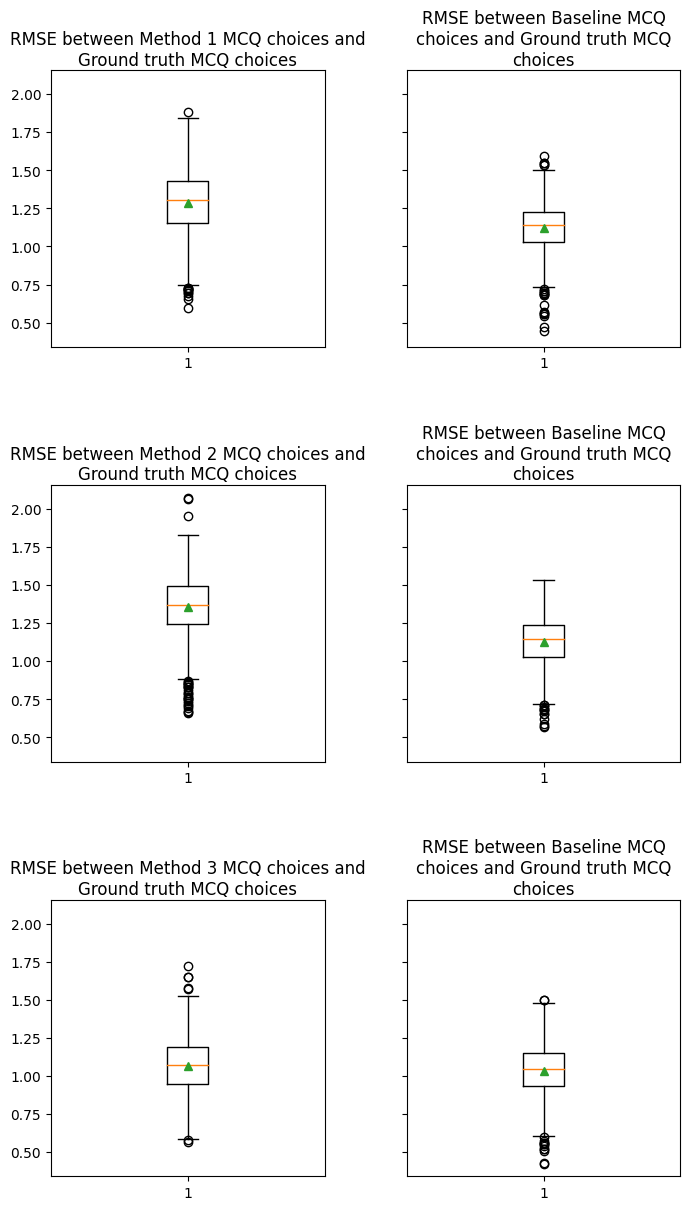

In [ ]:
# joined
with open(filedir + 'objective_output/MCQ Gen/' + filename + '_joined_latent_MCQ_baseline' + file_ext) as f:
  data = json.load(f)

method1_scores, method2_scores, method3_scores, baseline_method1_scores, baseline_method2_scores, baseline_method3_scores = getScores(data)

fig, ax = plt.subplots(nrows=3, ncols=2, sharey=True, figsize=(7,12))
ax[0,0].boxplot(method1_scores, showmeans=True)
ax[0,1].boxplot(baseline_method1_scores, showmeans=True)

ax[1,0].boxplot(method2_scores, showmeans=True)
ax[1,1].boxplot(baseline_method2_scores, showmeans=True)

ax[2,0].boxplot(method3_scores, showmeans=True)
ax[2,1].boxplot(baseline_method3_scores, showmeans=True)

ax[0,0].set_title('RMSE between Method 1 MCQ choices and Ground truth MCQ choices', wrap=True)
ax[0,1].set_title('RMSE between Baseline MCQ choices and Ground truth MCQ choices', wrap=True)
ax[1,0].set_title('RMSE between Method 2 MCQ choices and Ground truth MCQ choices', wrap=True)
ax[1,1].set_title('RMSE between Baseline MCQ choices and Ground truth MCQ choices', wrap=True)
ax[2,0].set_title('RMSE between Method 3 MCQ choices and Ground truth MCQ choices', wrap=True)
ax[2,1].set_title('RMSE between Baseline MCQ choices and Ground truth MCQ choices', wrap=True)
fig.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

## Evaluation using Distractor Discriminator

In [ ]:
!pip install -q transformers
!pip install -q json-lines
!pip install -q textstat
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import BertModel, BertTokenizer
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
torch.manual_seed(1)
import numpy as np
from torch.utils.data import Dataset, DataLoader
import textstat

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-50")
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def preprocess(passage):
    # https://stackoverflow.com/questions/1276764/
    preprocess_pipeline = passage.lower()
    preprocess_pipeline = re.sub(r'[^a-zA-Z0-9]', ' ', preprocess_pipeline)
    preprocess_pipeline = preprocess_pipeline.split()
    preprocess_pipeline = [wordnet_lemmatizer.lemmatize(token) for token in preprocess_pipeline]
    return preprocess_pipeline

In [ ]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout,embedding, bidirectional=True):
        super(CustomLSTM, self).__init__()
        self.embedding = embedding
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(dropout)
        if dropout > 0.0 and num_layers == 1:
            dropout = 0.0

        self.context_lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, dropout=dropout,
                            bidirectional=bidirectional, batch_first=True)
        
        self.fc = nn.Linear(2 * hidden_size, 1)
    def forward(self, c_ids,token_type_ids):
        context_embeddings = c_ids
        lstm_out, (hidden_context,cell) = self.context_lstm(context_embeddings)
        lstm_out = self.dropout(lstm_out)

        hidden = self.dropout(torch.cat((hidden_context[-2,:,:], hidden_context[-1,:,:]), dim = 1))
        y  = self.fc(hidden)
        log_probs = torch.sigmoid(y)
        return log_probs.flatten()

In [ ]:
class DistractorDB(Dataset):    
    def __init__(self, file, tokenizer,args):
        super().__init__()
        self.tokenizer = tokenizer
        self.max_c_len = args.max_c_len
        self.max_d_len = args.max_d_len
        self.max_comb_len = args.max_d_len + args.max_d_len+3
        
        self.all_answers = []
        self.all_distractors = []
        self.context_lengths = []
        self.context_readability = []
        self.chosen_method_number = args.chosen_method_num
        self.baseline_mode = args.baseline_mode
        self.number_of_distractors = 0
        with open(file) as f:
            data = json.load(f)

        for topic in data['data']:
          for paragraph in topic['paragraphs']:
              context = paragraph['context']
              context_readability = textstat.smog_index(context)
              answer = paragraph[f'method{self.chosen_method_number}']['generated_choices'][0]
              if self.baseline_mode:
                  distractors = np.unique(paragraph[f'baseline_method{self.chosen_method_number}']['generated_choices'])
              else:
                  distractors = np.unique(paragraph[f'method{self.chosen_method_number}']['generated_choices'][1:])
              self.number_of_distractors += 3

              a_ids = np.zeros((50,))
              answer_tokens = preprocess(answer)
              for token in answer_tokens:
                if token in word_vectors:
                  a_ids += word_vectors[token]

              d_list = []
              for distractor in distractors:
                d_ids = np.zeros((50,))
                distractor_tokens = preprocess(distractor)
                for token in distractor_tokens:
                  if token in word_vectors:
                    d_ids += word_vectors[token]
                # d_list.append(d_ids)
                self.all_answers.append(a_ids)
                self.all_distractors.append(d_ids)     
                self.context_lengths.append(len(context))
                self.context_readability.append(context_readability)
        # assert len(self.all_answers) == len(self.all_distractors)
        # assert len(self.all_answers) == len(self.all_distractors)

                
    def __len__(self):
      return len(self.all_answers)

    def __getitem__(self, index):
      combined_ids = torch.cat([torch.from_numpy(self.all_answers[index]).float(),torch.from_numpy(self.all_distractors[index]).float()]).float()

      return combined_ids, self.context_lengths[index], self.context_readability[index]

In [ ]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def setArguments(myData=[], maxParaCount=float("inf"), seed=1004, bert_model="bert-base-uncased", max_length=384, batch_size=64, ratio=1, k = 1):
    args = dict()
    args['maxParaCount'] = maxParaCount
    args['seed'] = seed
    args['myData'] = myData
    args['bert_model'] = bert_model
    args['max_length'] = max_length
    args['batch_size'] = batch_size
    args['output_dir'] = "../data/synthetic_data/"
    args['ratio'] = ratio
    args['k'] = k
    args['max_c_len']=384
    args['max_q_len']=64
    args['max_d_len']=15
    args['squad'] = True
    
    return dotdict(args)    
args = setArguments()

In [ ]:
!pwd

/content/drive/MyDrive/Question Generation/vae


In [ ]:
class Embedding(nn.Module):
    def __init__(self, bert_model):
        super(Embedding, self).__init__()
        bert_embeddings = BertModel.from_pretrained(bert_model).embeddings
        self.word_embeddings = bert_embeddings.word_embeddings
        self.token_type_embeddings = bert_embeddings.token_type_embeddings
        self.position_embeddings = bert_embeddings.position_embeddings
        self.LayerNorm = bert_embeddings.LayerNorm
        self.dropout = bert_embeddings.dropout

    def forward(self, input_ids, token_type_ids=None, position_ids=None):
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        if position_ids is None:
            seq_length = input_ids.size(1)
            position_ids = torch.arange(
                seq_length, dtype=torch.long, device=input_ids.device)
            position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        words_embeddings = self.word_embeddings(input_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)
        position_embeddings = self.position_embeddings(position_ids)

        embeddings = words_embeddings + token_type_embeddings + position_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        
        return embeddings

In [ ]:
embedding = Embedding('bert-base-uncased')
model = CustomLSTM(input_size=100,
                  hidden_size=100, 
                  num_layers=1,
                  dropout=0.5,
                  bidirectional=True,embedding=embedding).to(device)
model.load_state_dict(torch.load("../../Second/MCQ/discriminator_model/discriminator12.pth"))
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CustomLSTM(
  (embedding): Embedding(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (token_type_embeddings): Embedding(2, 768)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (context_lstm): LSTM(100, 100, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)

In [ ]:
# test_dataset = DistractorDB(filedir + 'objective_output/MCQ Gen/' + filename + '_latent_MCQ_baseline' + file_ext,tokenizer,args)
# test_joined_dataset = DistractorDB(filedir + 'objective_output/MCQ Gen/' + filename + '_joined_latent_MCQ_baseline' + file_ext,tokenizer,args)

In [ ]:
def evaluateDataset(dataloader, model):
  running_score = 0
  metrics = torch.empty((0, 3), dtype=torch.float32)
  for (context_ids, lengths, readability_list) in dataloader:
    with torch.no_grad():
      context_ids = context_ids.to(device)            
      predictions = model(context_ids.unsqueeze(1),None)
      metrics = torch.cat((metrics, torch.stack([predictions.cpu(), lengths, readability_list], dim=1)), dim=0)
      condition = predictions < 0.5
      predictions[condition] = 0
      predictions[~condition] = 1
      # print(predictions.sum())
      running_score += predictions.sum()
      # print(metrics.shape)
      # print(predictions.shape)
      # print(lengths.shape)
      # print(readability_list.shape)
      # print(torch.stack([predictions.cpu(), lengths, readability_list], dim=1).shape)
  accuracy = running_score / dataloader.dataset.number_of_distractors
  return metrics, accuracy

In [ ]:
import re

In [ ]:
filename = 'sciq_test'
file_ext = '.json'
filedir = '../data/squad/'
metric_dict = dict()
for joined in [False, True]:
  if joined:
      filepath = filedir + 'objective_output/MCQ Gen/' + filename + '_joined_latent_MCQ_baseline' + file_ext
      print("On SciQ dataset with extended contexts:")
  else:
      filepath = filedir + 'objective_output/MCQ Gen/' + filename + '_latent_MCQ_baseline' + file_ext
      print("On SciQ dataset:")
  for baseline in [False, True]:
    for method_num in [1,2,3]:
        args.baseline_mode = baseline
        args.chosen_method_num = method_num
        dataset = DistractorDB(filepath, tokenizer, args)
        dataloader = DataLoader(dataset,batch_size=64,shuffle=False,num_workers=1)
        metrics, accuracy = evaluateDataset(dataloader, model)
        metric_dict[(joined, baseline, method_num)] = metrics
        if baseline:
          print(f"\tThe accuracy for baseline distractors made from Method {method_num} answer: {accuracy:0.4f}")
        else:
          print(f"\tThe accuracy for Method {method_num} distractors: {accuracy:0.4f}")

On SciQ dataset:
	The accuracy for Method 1 distractors: 0.3154
	The accuracy for Method 2 distractors: 0.1980
	The accuracy for Method 3 distractors: 0.3390
	The accuracy for baseline distractors made from Method 1 answer: 0.5329
	The accuracy for baseline distractors made from Method 2 answer: 0.5589
	The accuracy for baseline distractors made from Method 3 answer: 0.4573
On SciQ dataset with extended contexts:
	The accuracy for Method 1 distractors: 0.2325
	The accuracy for Method 2 distractors: 0.1967
	The accuracy for Method 3 distractors: 0.3093
	The accuracy for baseline distractors made from Method 1 answer: 0.5126
	The accuracy for baseline distractors made from Method 2 answer: 0.6154
	The accuracy for baseline distractors made from Method 3 answer: 0.5321


In [ ]:
import pickle
with open(filedir + 'objective_output/MCQ Gen/sciq_metrics.pickle', 'wb') as h:
    pickle.dump(metric_dict, h)

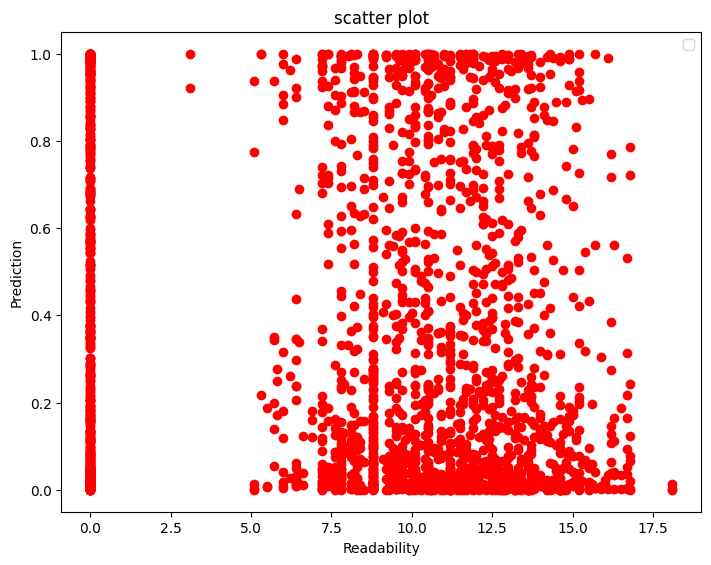

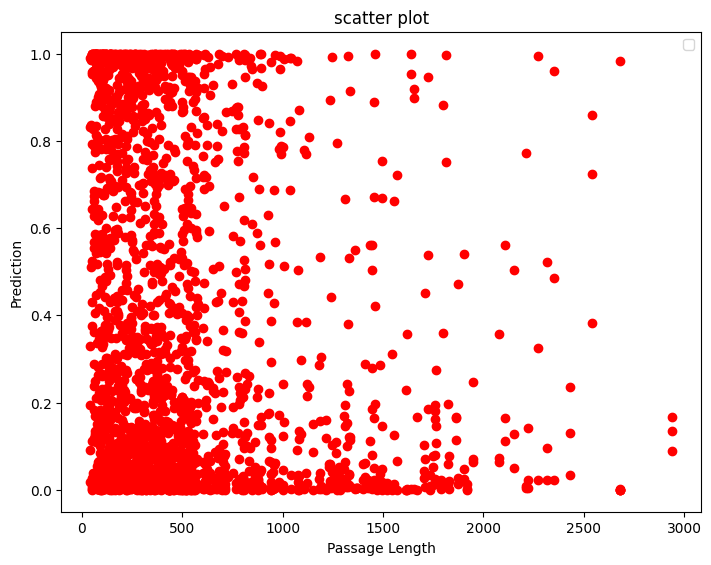

In [ ]:
import matplotlib.pyplot as plt
metrics = metric_dict[list(metric_dict.keys())[0]]
predictions = metrics[:,0]
passage_lengths = metrics[:,1]
passage_readability = metrics[:,2]
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(passage_readability, predictions, color='r')
ax.legend()
ax.set_xlabel('Readability')
ax.set_ylabel('Prediction')
ax.set_title('scatter plot')
plt.show()

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(passage_lengths, predictions, color='r')
ax.legend()
ax.set_xlabel('Passage Length')
ax.set_ylabel('Prediction')
ax.set_title('scatter plot')
plt.show()